# EDA

Импортируем библиотеки и прописываем пути, устанавливаем random_state.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
PATH_COVERS = 'data/raw/covers.json'
PATH_LYRICS = 'data/raw/lyrics.json'
PATH_META = 'data/raw/meta.json'

## Изучение датасета covers 

Изучим данные в датасете covers данный датасет содержит следующие столбцы  
- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

In [3]:
df_covers = pd.read_json(PATH_COVERS, lines=True)
df_covers.head()

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER


Выведем информацию по датасету

In [4]:
df_covers.shape

(71597, 3)

In [5]:
df_covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


У нас 71597 записей при этом в id оригинальных треков есть много пропусков

Посмотрим на соотношение оригинальных и версий и каверов в полном датасете

In [6]:
df_group = df_covers.groupby('track_remake_type')['track_id'].agg('count').reset_index()

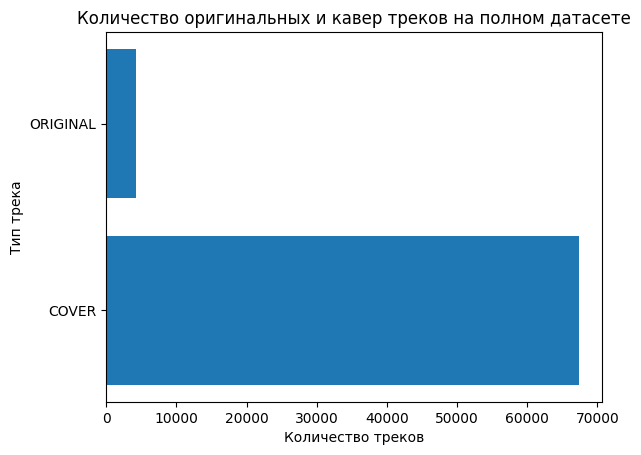

In [7]:
plt.title('Количество оригинальных и кавер треков на полном датасете')
plt.barh(df_group['track_remake_type'], df_group['track_id'])
plt.xlabel('Количество треков')
plt.ylabel('Тип трека')
plt.show()

Посмотрим на соотношение оригинальных и версий и каверов в датасете без пропусков

In [8]:
df_group = df_covers.dropna().groupby('track_remake_type')['track_id'].agg('count').reset_index()

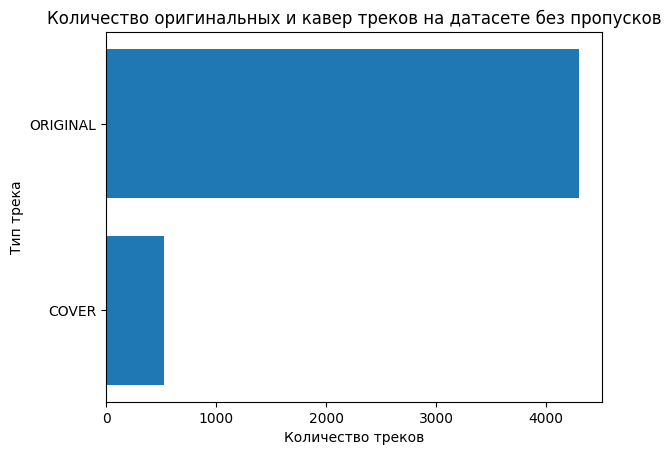

In [9]:
plt.title('Количество оригинальных и кавер треков на датасете без пропусков')
plt.barh(df_group['track_remake_type'], df_group['track_id'])
plt.xlabel('Количество треков')
plt.ylabel('Тип трека')
plt.show()

Посмотрим сколько треков имеют не только ссылку на оригинальный id, но и сам трек находится в выборке

In [10]:
df_covers_copy = df_covers.copy(deep=True)
df = df_covers[['track_id']].merge(df_covers_copy, left_on='track_id', right_on='original_track_id')
df[df['track_remake_type']=='COVER'].shape[0]

297

Всего у нас 297 таких треков, что учитывая будущую размерность векторизированных данных очень мало. Однако это единственные размеченные данные с которыми мы можем корректно работать и в дальнейшем оценивать качество нашей модели.

Изучим преведены ли у нас случаи цепочки каверов (когда один кавер делается из другого). Выберем строки с каверами и посмотрим у скольки из них не равны track_id_x и original_track_id.

In [11]:
df_с = df[df['track_remake_type']=='COVER']

In [12]:
(df_с['track_id_x'] != df_с['original_track_id']).sum()

0

Таких цепочек нет. 

Также рассмотрим ситуацию когда от одного оригинала делается несколько каверов.

In [13]:
df_group = df_с.groupby('original_track_id')['track_id_y'].agg('count').reset_index()
df_group = df_group.sort_values('track_id_y')
df_group = df_group.tail(20)

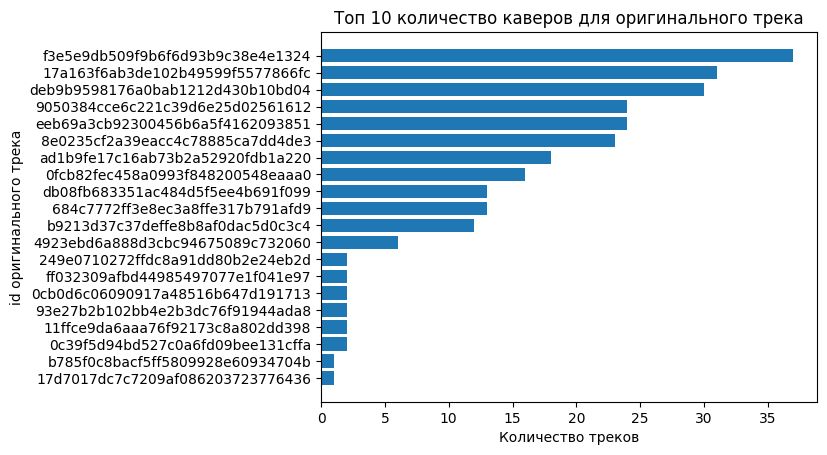

In [14]:
plt.title('Топ 10 количество каверов для оригинального трека')
plt.barh(df_group['original_track_id'], df_group['track_id_y'])
plt.xlabel('Количество треков')
plt.ylabel('id оригинального трека')
plt.show()

В большинстве случаев у песни только один кавер, но есть песни у которых каверов больше 20

Посмотрим, сколько строк с типом COVER имеют ненулевой столбец original_track_id  

In [15]:
df = df_covers[df_covers['track_remake_type']=='COVER']
df[~df['original_track_id'].isna()].shape[0]

528

Получается, что в данных 528 строк с типом COVER, которые имеют ненулевыую ссылку на original_track_id, но при этом сами оригинальные треки в датасете есть только у 297.

## Изучение датасета lyrics

Изучим данные в датасете lyrics данный датасет содержит следующие столбцы  
- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

In [16]:
df_lyrics = pd.read_json(PATH_LYRICS, lines=True)
df_lyrics.head()

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659


Выведем информацию по датасету

In [17]:
df_lyrics.shape

(11414, 3)

In [18]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


У нас есть слова только для 11414 песен. Посмотрим количество уникальных текстов по сравнению с количеством песен.

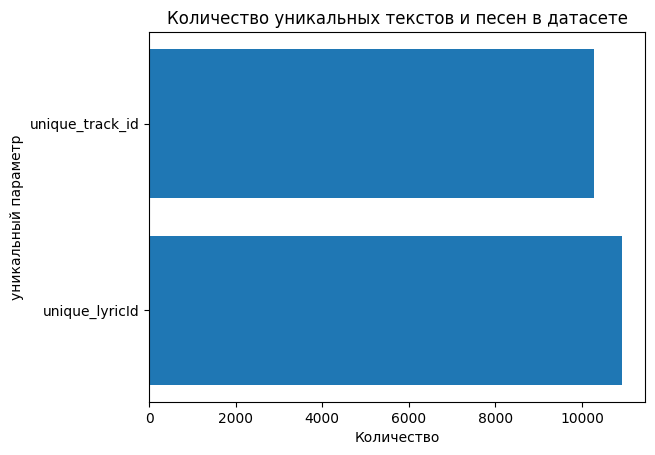

In [19]:
plt.title('Количество уникальных текстов и пеcен в датасете')
plt.barh(['unique_lyricId','unique_track_id'], [len(df_lyrics['lyricId'].unique()), len(df_lyrics['track_id'].unique())])
plt.xlabel('Количество')
plt.ylabel('уникальный параметр')
plt.show()

In [20]:
print(f'Количество строк в датасете lyrics: {df_lyrics.shape[0]}')

Количество строк в датасете lyrics: 11414


In [21]:
print(f'Количество уникльных текстов: {len(df_lyrics["lyricId"].unique())}')

Количество уникльных текстов: 10915


In [22]:
print(f'Количество уникльных треков: {len(df_lyrics["track_id"].unique())}')

Количество уникльных треков: 10277


Количество уникальных треков даже меньше чем количество уникальных текстов. Посмотрим на track_id, которые повторяются

In [23]:
list_duplicate_id = list(df_lyrics[df_lyrics['track_id'].duplicated()]['track_id'].values)

In [24]:
df_lyrics[df_lyrics['track_id'].isin(list_duplicate_id)].sort_values('track_id').head()

,lyricId,text,track_id
10681,039236cf5355b4a81a7d5e689dbbf00a,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
10686,0abe3bb343894590423064dee2d2a114,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
10676,745f700051961898c65ffdafd9793584,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
4796,9ee5ee7522b5b6d045a2d276a040d00c,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a
11306,1682f991cfa94d1440bef2aa417edec7,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a


Возможно в данных есть какая-то неточность в момент поступления информации и поэтому для одинаковых track_id могут получаться разные lyricId. Удалим столбец lyricId и проверим на дубликаты

In [25]:
df_lyrics = df_lyrics.drop('lyricId', axis=1)

Выведем количество дубликатов

In [26]:
df_lyrics.duplicated().sum()

264

Удалим дубликаты и проверим на повторение данных

In [27]:
df_lyrics = df_lyrics.drop_duplicates()

In [28]:
list_duplicate_id = list(df_lyrics[df_lyrics['track_id'].duplicated()]['track_id'].values)

In [29]:
df_lyrics[df_lyrics['track_id'].isin(list_duplicate_id)].sort_values('track_id').head()

,text,track_id
10676,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
10681,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
4796,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a
9220,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a
11306,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a


Тексты всё равно схожи, рассмотрим на примере первых двух строк в чём может быть проблема

In [30]:
df_lyrics[df_lyrics['track_id'].isin(list_duplicate_id)].sort_values('track_id').iloc[0]['text']

"Hearts go astray\nLeaving hurt when they go\nI went away\nJust when you needed me so\n\nFilled with regret\nI come back beggin' you\nForgive, forget\nWhere's the love we once knew?\n\nOpen up your eyes\nThen you'll realize\nHere I stand with my\nEverlastin' love\n\nNeed you by my side\nWanna be your bride\nYou'll never be denied\nEverlastin' love\n\nFrom the very start\nOpen up your heart\nBe a lastin' part of\nEverlastin' love\n(Real love will last forever)\n(Real love will last forever)\n\nWhen life's river flows\nNo one really knows\nTill someone's there to show\nThe way to lastin' love\n\nLike the sun that shines\nEndlessly shines\nYou always will be mine\nIt's eternal love\n\nWhen other loves are gone\nOurs will be strong\nWe have our very own\nEverlastin' love\nLove\n(Real love will last forever)\nLove\n(Real love will last forever)\n\nYou give me, you give me\nYou give me, everlastin' love\nYou give me, you give me\nYou give me, everlastin' love\n\n(You give me, you give me)\n(

In [31]:
df_lyrics[df_lyrics['track_id'].isin(list_duplicate_id)].sort_values('track_id').iloc[1]['text']

"Hearts go astray\nLeaving hurt when they go\nI went away\nJust when you needed me so\nFilled with regret\nI come back beggin' you\nForgive, forget\nWhere's the love we once knew?\nOpen up your eyes\nThen you'll realize\nHere I stand with my\nEverlastin' love\nNeed you by my side\nWanna be your bride\nYou'll never be denied\nEverlastin' love\nFrom the very start\nOpen up your heart\nBe a lastin' part of\nEverlastin' love\n(Real love will last forever)\n(Real love will last forever)\nWhen life's river flows\nNo one really knows\nTill someone's there to show\nThe way to lastin' love\nLike the sun that shines\nEndlessly shines\nYou always will be mine\nIt's eternal love\nWhen other loves are gone\nOurs will be strong\nWe have our very own\nEverlastin' love\nLove\n(Real love will last forever)\nLove\n(Real love will last forever)\nYou give me, you give me\nYou give me, everlastin' love\nYou give me, you give me\nYou give me, everlastin' love\n(You give me, you give me)\n(You give me, everl

Как видим разница состоит в том, что в первом тексте иногда стоит два переноса строк, а во втором один. Приведём весь текст в данном столбце к стандартному виду (сделаем все буквы маленькие, заменим символы переноса, табуляции, скобки на пробел, уберём двойные пробелы и снова проверим датасет на дубликаты)

In [32]:
list_bad_simbol = ['\n\n', '\n', '\t\t', '\t', '(', ')','  ']

In [33]:
for simbol in list_bad_simbol:
    df_lyrics['text'] = df_lyrics['text'].str.replace(simbol, ' ')
df_lyrics['text'] = df_lyrics['text'].str.lower()

Проверим результат

In [34]:
df_lyrics[df_lyrics['track_id'].isin(list_duplicate_id)].sort_values('track_id').iloc[0]['text']

"hearts go astray leaving hurt when they go i went away just when you needed me so filled with regret i come back beggin' you forgive, forget where's the love we once knew? open up your eyes then you'll realize here i stand with my everlastin' love need you by my side wanna be your bride you'll never be denied everlastin' love from the very start open up your heart be a lastin' part of everlastin' love real love will last forever  real love will last forever when life's river flows no one really knows till someone's there to show the way to lastin' love like the sun that shines endlessly shines you always will be mine it's eternal love when other loves are gone ours will be strong we have our very own everlastin' love love real love will last forever love real love will last forever you give me, you give me you give me, everlastin' love you give me, you give me you give me, everlastin' love you give me, you give me  you give me, everlastin' love you know you give it to me everlastin' l

Выведем количество дубликатов

In [35]:
df_lyrics.duplicated().sum()

22

Удалим дубликаты и повторно проверим результат

In [36]:
df_lyrics = df_lyrics.drop_duplicates()
list_duplicate_id = list(df_lyrics[df_lyrics['track_id'].duplicated()]['track_id'].values)
df_lyrics[df_lyrics['track_id'].isin(list_duplicate_id)].sort_values('track_id').head()

,text,track_id
4796,"if i stay with you, if i'm choosing wrong i do...",0102189356af15ad0be804eddd9bc24a
11306,"if i stay with you, if i'm choosing wrong i do...",0102189356af15ad0be804eddd9bc24a
9220,"if i stay with you, if i'm choosing wrong i do...",0102189356af15ad0be804eddd9bc24a
8330,well sometimes i go out by myself and i look a...,02db8e8e8d3c08f3a57cc6db3876f942
591,well sometimes i go out by myself and i look a...,02db8e8e8d3c08f3a57cc6db3876f942


In [37]:
df_lyrics[df_lyrics['track_id'].isin(list_duplicate_id)].sort_values('track_id').iloc[0]['text']

"if i stay with you, if i'm choosing wrong i don't care at all if i'm losing now, but i'm winning late that's all i want now we need some space, 'cause i feel for you and i wanna change growing up alone, it seems so short i can't explain i don't care at all i don't care at all i will be so strong, looking for a new version of myself 'cause now all i want is to be a part of my new world whatever happens in the future, trust in destiny don't try to make anything else even when you feel i don't care at all i don't care at all"

In [38]:
df_lyrics[df_lyrics['track_id'].isin(list_duplicate_id)].sort_values('track_id').iloc[1]['text']

"if i stay with you, if i'm choosing wrong i don't care at all if i'm losing now, but i'm winning late that's all i want now we need some space 'cause i feel for you and i wanna change growing up alone, it seems so short i can't explain whatever happens in the future, trust in destiny, oh-oh, oh-oh don't try to make anything else, even when you feel i don't care at all i don't care at all lost my time, my life is going on i will be so strong, looking for a new version of myself 'cause now all i want is to be a part of my new world whatever happens in the future, trust in destiny don't try to make anything else, even when you feel i don't care at all i don't care at all why not have it all? i don't care at all lost my time, my life is going on lost my time, my life is going on lost my time, my life is going on, ooh-ooh ooh-ooh, ooh-ooh"

In [39]:
df_lyrics[df_lyrics['track_id'].isin(list_duplicate_id)].sort_values('track_id').iloc[2]['text']

"if i stay with you, if i'm choosing wrong i don't care at all if i'm loosing now, but i'm winning late that's all i want now we need some space 'cause i feel for you and i wanna change growing up alone, it seems so short i can't explain whatever happens in the future, trust in destiny don't try to make anything else, even when you feel i don't care at all, i am lost i don't care at all lost my time, my life is going on i will be so strong, looking for a new version of myself 'cause now all i want is to be a part of my new world whatever happens in the future, trust in destiny don't try to make anything else, even when you feel i don't care at all, i am lost i don't care at all why not have it all? i am lone i don't care at all lost my time, my life is going on"

Получается, что в датасете есть песни с одинаковым track_id, но с разными текстами, возможно это связано с вариантами исполнения (студийная запись, концертная и т.д.). Так что единственный вариант, это очищать от дубликатов по track_id.

## Изучение датасета meta

Изучим данные в датасете meta данный датасет содержит следующие столбцы  

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

In [40]:
df_meta = pd.read_json(PATH_META, lines=True, convert_dates=['dttm'])
df_meta.head()

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0


Сразу проверим дубликаты в track_id

In [41]:
df_meta.duplicated(subset='track_id').sum()

0

И в isrc

In [42]:
df_meta.duplicated(subset='isrc').sum()

485

Посмотрим какие треки имеют повторяющийся isrc

In [43]:
list_duplicate_isrc = list(df_meta[df_meta['isrc'].duplicated()]['isrc'].values)
df_meta[df_meta['isrc'].isin(list_duplicate_isrc)].sort_values('isrc').head()

,track_id,dttm,title,language,isrc,genres,duration
27012,be0233f57dbb59079929ac646b0b9d5c,2021-07-06 16:38:30,Zivot da stane ne sme,None,ATAJ12100470,[FOLK],151190.0
26955,8aff9d28865aaf1fa44e46b82cba0f63,2021-07-06 15:38:37,Burma,None,ATAJ12100470,[FOLK],179300.0
51052,196a0973d73122891a426f8334105ce7,2019-03-29 21:00:00,Inní mér syngur vitleysingur,EN,ATN261668711,"[FOLKMETAL, METAL]",237010.0
66395,425761c88ebc69e89c748eb537671953,2018-04-28 19:08:26,Inni Mer Syngur Vitleysingur,None,ATN261668711,"[FOLKMETAL, METAL]",237010.0
66396,466df43223bcc7e5d0973e9038890fb7,2018-04-28 19:08:26,Nattfodd,None,ATN261668712,"[FOLKMETAL, METAL]",255380.0


Получились весьма неоднозначные данные. У нас есть дубликаты в уникальном идентификаторе, но при этом могут отличаться даже названия песен, может отсутствовать метка языка (это может быть связано как с тем, что это инструментальное исполнение, так и с тем, что данных по языку отсутствуют)

Построим гистограмму распространения языка.

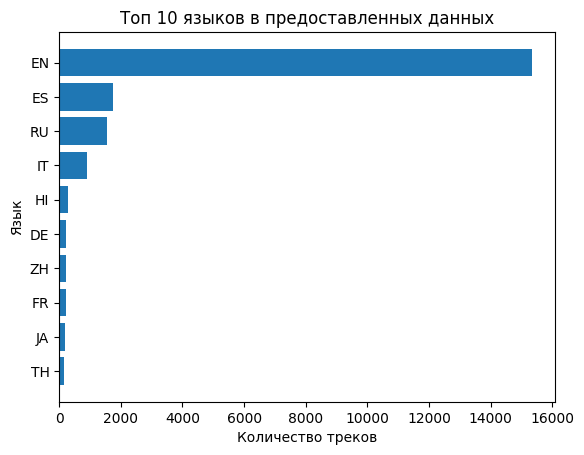

In [44]:
df_group = df_meta['language'].value_counts(ascending=True).reset_index()
df_group = df_group.tail(10)
plt.title('Топ 10 языков в предоставленных данных')
plt.barh(df_group['language'], df_group['count'])
plt.xlabel('Количество треков')
plt.ylabel('Язык')
plt.show()

Как видим наиболее часто в данных встречаются треки на английском, значительно реже на испанском, русском и итальянском.

Выведем количество строк в которых язык не указан.

In [45]:
df_meta['language'].isna().sum()

49800

У нас почти 49800 строк без указания языка и это как-то необходимо будет обработать

Изучим как распределена продолжительность треков

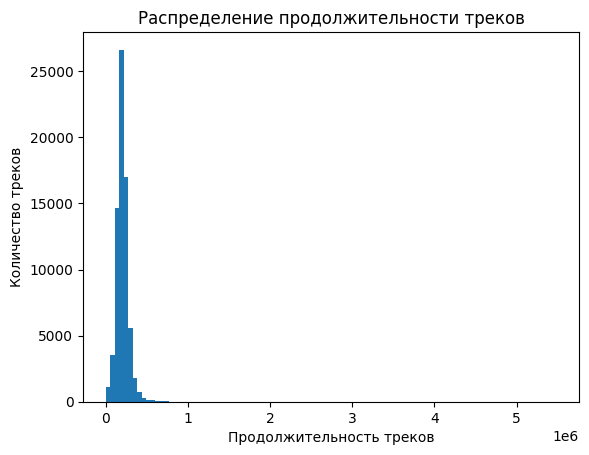

In [46]:
plt.title('Распределение продолжительности треков')
plt.hist(df_meta['duration'], bins=100)
plt.xlabel('Продолжительность треков')
plt.ylabel('Количество треков')
plt.show()

В данных есть явные выбросы, определим их границы при помощи box plot, но предварительно проверим данный столбец на наличие пропусков.

In [47]:
df_meta['duration'].isna().sum()

1

Пропуск действительно есть, но он один, поэтому удалим его и построим диаграмму

In [48]:
df_meta = df_meta.dropna(subset='duration')

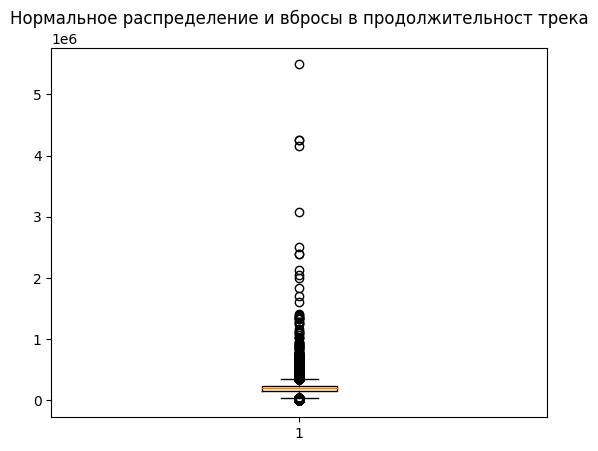

In [49]:
plt.title('Нормальное распределение и вбросы в продолжительност трека')
plt.boxplot(df_meta['duration'])
plt.show()

Если анализировать boxplot, то формально выбросами можно считать значения свыше 400000, однако значения идут достаточно плотно, поэтому повторно построим гистограмму, но уже на участке до 1000000

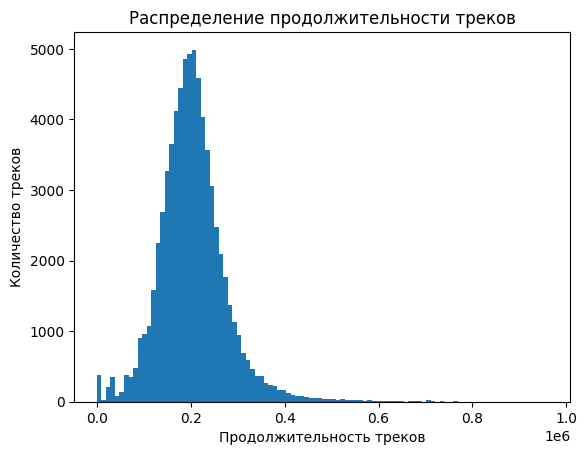

In [50]:
df = df_meta[df_meta['duration'] < 1.0e6]
plt.title('Распределение продолжительности треков')
plt.hist(df['duration'], bins=100)
plt.xlabel('Продолжительность треков')
plt.ylabel('Количество треков')
plt.show()

Продолжительность трека имеет нормально распределение с длинным правым хвостом, действительно условной границей выбросов можно считать 400000. Также стоит отметить, что у нас имеются выбросы в районе 0, чтобы их проанализировать построим гистограму треков с продолжительностью менее 0,05e6

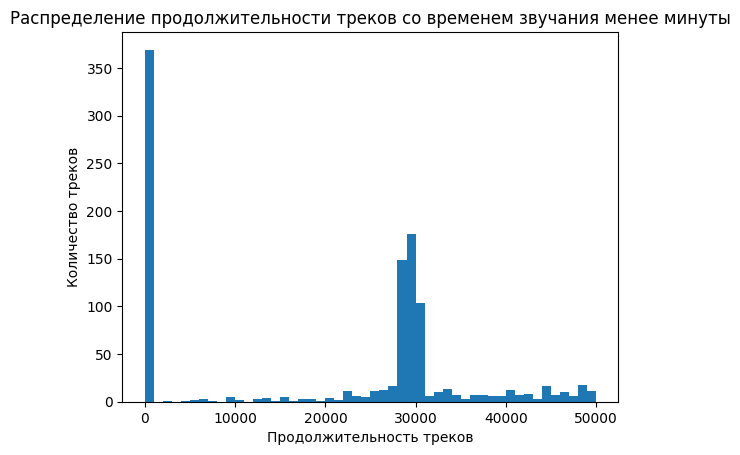

In [51]:
df = df_meta[df_meta['duration'] < 0.05e6]
plt.title('Распределение продолжительности треков со временем звучания менее минуты')
plt.hist(df['duration'], bins=50)
plt.xlabel('Продолжительность треков')
plt.ylabel('Количество треков')
plt.show()

В данны хесть выброс в районе 0 секунд (возможно это дефолтное заполнение времени трека, если его длина не известна). Так же имеются выбросы в районе 30 секунд.

Изучим первую дату появления трекак в датасете

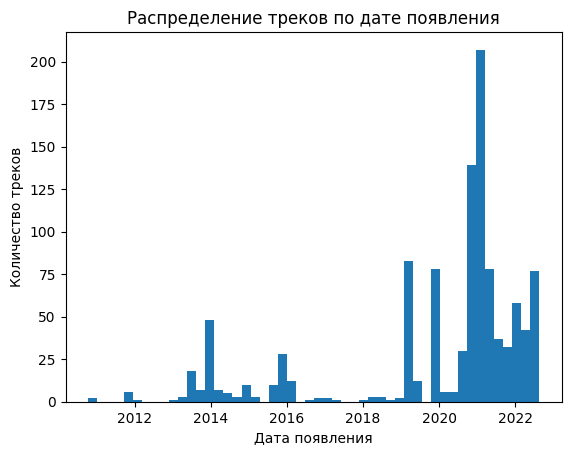

In [52]:
plt.title('Распределение треков по дате появления')
plt.hist(df['dttm'], bins=50)
plt.xlabel('Дата появления')
plt.ylabel('Количество треков')
plt.show()

Видно, что в 2020 и позднее появилось очень много треков, так же наблюдается увеличение количества треков ближе к началу года начиная с 2014. Однако стоит уточнить данная дата это доата появления трека в базе или это дата создания самой песни.

Изучим распределение жанров. Для начала сформируем общий список со всеми вхождениями жанров

In [53]:
list_all_genres = []
for genre in df_meta['genres'].values:
    list_all_genres += genre

Теперь сформируем список с уникальными жанрами и посмотрим на его длину

In [54]:
list_unique_genre = list(set(list_all_genres))
len(list_unique_genre)

128

В дата сете 128 уникальных жанров

Создадим датасет с перечнем уникальных жанров и количеством вхождений этих жанров

In [55]:
df = pd.DataFrame({'genre': list_unique_genre})
df['count'] =  df['genre'].apply(lambda x: list_all_genres.count(x))
df = df.sort_values('count')

Выведем топ 20 жанров 

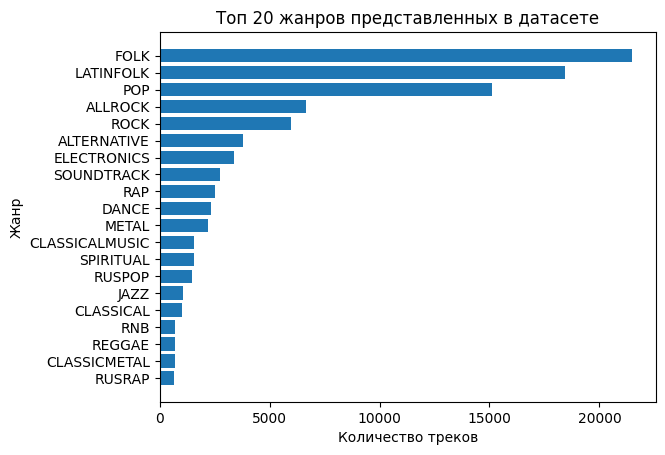

In [56]:
df = df.tail(20)
plt.title('Топ 20 жанров представленных в датасете')
plt.barh(df['genre'], df['count'])
plt.xlabel('Количество треков')
plt.ylabel('Жанр')
plt.show()

Больше всего в датасете треков с жанрами FOLK, LATINFOLK и POP дальше с большим отрывом идут ALLROCK, и ROCK.

In [ ]:
(df_meta['isrc'].apply(lambda x: len(x) if x is not None else None).value_counts()

In [ ]:
df_meta[df_meta['isrc'].apply(lambda x: len(x) if x is not None else None)==15]

## Изучение объединённого датасета

Для дальнейшей работы объединим три датасета в один при этом:

- в датасете df_covers оставим только строки у которых есть ссылка на оригинальный трек
- в df_lyrics удалим дубликаты по столбцу track_id
- в df_meta удалим треки продолжительностью 0 секунд

In [57]:
df_covers = df_covers.dropna()
df_lyrics = df_lyrics.drop_duplicates(subset='track_id')
df_meta = df_meta[df_meta['duration']!=0]

Выведем информацию о размерах получишихся датасетов

In [58]:
df_covers.shape, df_lyrics.shape, df_meta.shape

((4821, 3), (10277, 2), (71399, 7))

Объединим получившиеся датасеты и удалим пустые строки

In [59]:
df_union = (df_covers.merge(df_lyrics, on = 'track_id', how = 'inner')
                     .merge(df_meta, on = 'track_id', how = 'inner'))

Выведем размер получившигося датасета

In [60]:
df_union.shape

(3041, 10)

Выведем общую информацию по датасету

In [61]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3041 entries, 0 to 3040
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  3041 non-null   object        
 1   track_id           3041 non-null   object        
 2   track_remake_type  3041 non-null   object        
 3   text               3041 non-null   object        
 4   dttm               3041 non-null   datetime64[ns]
 5   title              3041 non-null   object        
 6   language           2000 non-null   object        
 7   isrc               2999 non-null   object        
 8   genres             3041 non-null   object        
 9   duration           3041 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 237.7+ KB


У нас есть много пропусков в столбце с языками, но при этом тексты к ним точно есть. Посмотрим на такие данные.

In [62]:
df_union[df_union['language'].isna()].head()

,original_track_id,track_id,track_remake_type,text,dttm,title,language,isrc,genres,duration
58,d6be27d62c712c227540376aeeed3a76,d6be27d62c712c227540376aeeed3a76,ORIGINAL,"просто здравствуй, просто как дела наверное та...",2009-12-31 21:00:00,Плачь и смотри,None,None,"[POP, RUSPOP]",204850.0
59,9d822b2f3a1911d9400a1dfb6dfd854a,9d822b2f3a1911d9400a1dfb6dfd854a,ORIGINAL,"такси, ну как котята, мурлыкали у ног а я в мо...",2009-12-31 21:00:00,Снег идёт,None,None,"[POP, RUSPOP]",236480.0
69,b043f59f4da7309dde538a51e6c93155,b043f59f4da7309dde538a51e6c93155,ORIGINAL,"¿qué horas son, mi corazón? ¿qué horas son, mi...",2018-11-12 21:00:00,Me Gustas Tú,None,FR84R0000004,[SKA],239980.0
93,2f1e8b8cb9a30b39d2b65ef1cbfc9a5b,2f1e8b8cb9a30b39d2b65ef1cbfc9a5b,ORIGINAL,i am lost in a rainbow now our rainbow is gone...,2014-03-22 20:00:00,In This Shirt,None,GBUM70916171,"[FILMS, SOUNDTRACK]",333840.0
99,cdc8954e5cd511bbe9d227a57736db7a,cdc8954e5cd511bbe9d227a57736db7a,ORIGINAL,"i know i stand in line, until you think you ha...",2011-01-10 21:00:00,Somethin' Stupid,None,USASE0510163,[POP],158930.0


Встречается достаточно много пропусков на руском, добавим временный столбец, в который будем записывать текст только на русском языке. Для этого создадим функцию, которая будет оставлять в строке только допустимые символы.

In [63]:
def clear_text(correct_simb: str, text: str) -> str:
    new_text = re.sub(correct_simb, ' ', text)    
    new_text = new_text.split()
    return ' '.join(new_text)

In [64]:
df_union['clear_text'] = df_union['text'].apply(lambda x: clear_text(r'[^а-яА-Я]', x))

Теперь укажем, что для строк, в которых у столбца clear_text не стоит пустая строка и language равен None поставим обозначение RU

In [65]:
df_union.loc[(df_union['clear_text'] != '') &
             (df_union['language'].isna()), 'language'] = 'RU' 

Удалим столбец clear_text и выведем информацию по датасету.

In [66]:
df_union = df_union.drop('clear_text', axis=1)

In [67]:
df_union.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3041 entries, 0 to 3040
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   original_track_id  3041 non-null   object        
 1   track_id           3041 non-null   object        
 2   track_remake_type  3041 non-null   object        
 3   text               3041 non-null   object        
 4   dttm               3041 non-null   datetime64[ns]
 5   title              3041 non-null   object        
 6   language           2862 non-null   object        
 7   isrc               2999 non-null   object        
 8   genres             3041 non-null   object        
 9   duration           3041 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 237.7+ KB


Нам удалось частично заполнить пропуски, но они ещё есть и единственный вариант достать их из стороних источников.

Проверим дубликаты по track_id

In [68]:
df_union['track_id'].duplicated().sum()

0

Посмотрим как в получившемся датасете соотносятся оригинальные и кавер-треки

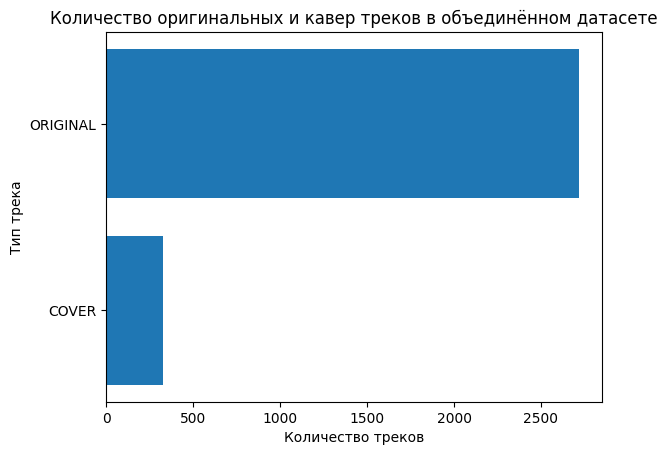

In [69]:
df_group = df_union.groupby('track_remake_type')['track_id'].agg('count').reset_index()
plt.title('Количество оригинальных и кавер треков в объединённом датасете')
plt.barh(df_group['track_remake_type'], df_group['track_id'])
plt.xlabel('Количество треков')
plt.ylabel('Тип трека')
plt.show()

В датасете все ещё значительно больше оригинальных треков, это нужно будет учесть при обучении классификатора

Рассмотрим соотношение языков

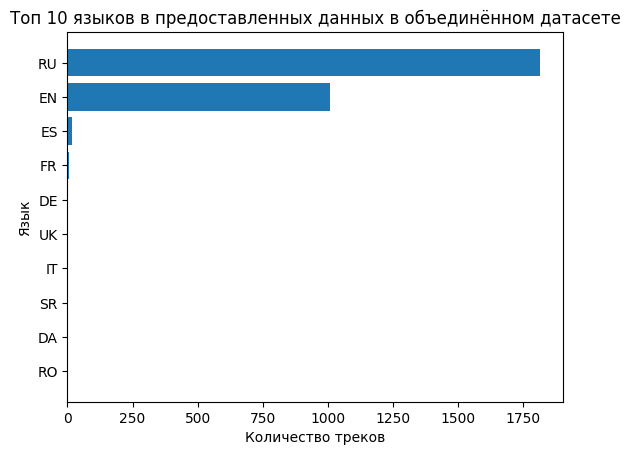

In [70]:
df_group = df_union['language'].value_counts(ascending=True).reset_index()
df_group = df_group.tail(10)
plt.title('Топ 10 языков в предоставленных данных в объединённом датасете')
plt.barh(df_group['language'], df_group['count'])
plt.xlabel('Количество треков')
plt.ylabel('Язык')
plt.show()

Соотношение языков резко изменилось очень сильно уменьшилось количество треков на английском и испанских языках. Вероятнее всего будет целесообразно при обучении моделей отдельно обучить модель на русском и английском языках, либо предусмотреть перевод текстов на один язык, но для этого придётся пользоваться сторонними библиотеками.

Проанализируем продолжительность треков в объединённом датасете

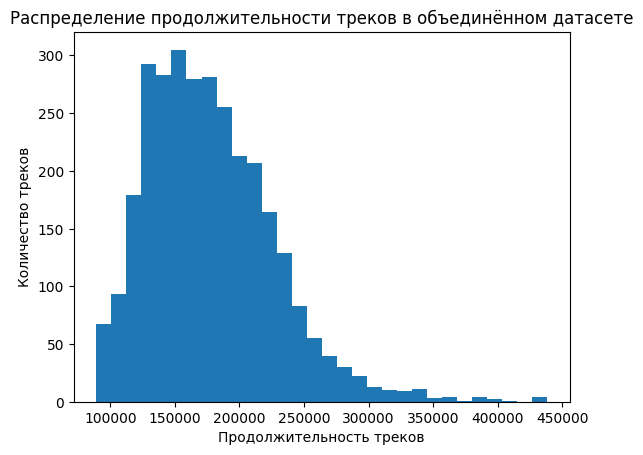

In [71]:
plt.title('Распределение продолжительности треков в объединённом датасете')
plt.hist(df_union['duration'], bins=30)
plt.xlabel('Продолжительность треков')
plt.ylabel('Количество треков')
plt.show()

Распределение продолжительности треков приблизилось к нормальному, при этом правый тяжёлый хвост остался, но выбросами будем становятся значения свыше 300000. Целесообразно будет проверить влияние чистки датасета на финальную метрику при обучении модели.

Посмотрим как изменилось рампределение  жанров в объединённом датасете

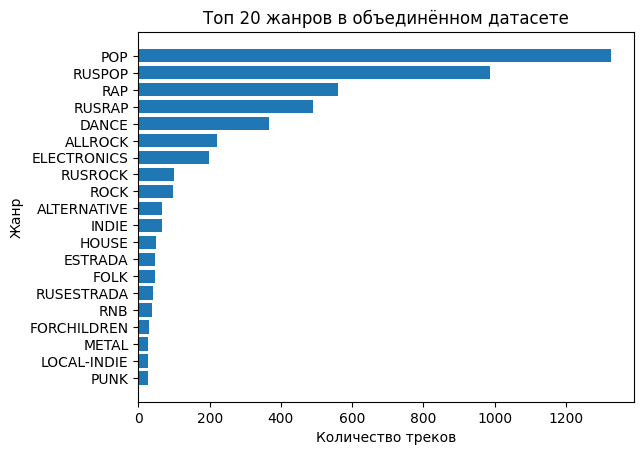

In [72]:
list_all_genres = []
for genre in df_union['genres'].values:
    list_all_genres += genre
    
list_unique_genre = list(set(list_all_genres))
len(list_unique_genre)

df = pd.DataFrame({'genre': list_unique_genre})
df['count'] =  df['genre'].apply(lambda x: list_all_genres.count(x))
df = df.sort_values('count')

df = df.tail(20)
plt.title('Топ 20 жанров в объединённом датасете')
plt.barh(df['genre'], df['count'])
plt.xlabel('Количество треков')
plt.ylabel('Жанр')
plt.show()

Распределение жанров в финальном датасете сильно отличается от полного датасета: FOLK и LATINFOLK ушли с первых мест, зато туда добавились RUSPOP, RAP и RUSRAP это может повлиять на качество модели в дальнейшем.

## Выводы

В данном разделе нами был проведён анализ данных, в ходе коотрого установленно следующее:

**df_covers**  
- имеет место большое количество пропусков в original_track_id это повлияет в дальнейшем на обучении модели, поскольку нам потребуется найти оригинальный трек;
- в датасете 528 строк с типом COVER, которые имеют ненулевыую ссылку на original_track_id, но при этом сами оригинальные треки в датасете есть только у 297, что также сужает количество данных для обучения.

**df_lyrics** 
- в датасете задублированы track_id при этом они меют разные lyricId. При этом сам текст может как полностью совпадать или иметь специфику записи (например в одном варианте может стоять двойной перенос при отбивке припева, а в другом одинарный), так и иметь разные варианты. Было выдвинуто предположение, что это связано с разными вариантами записи (студийная, концертная), но при этом странно, что track_id разный. В качестве решения проблемы (чтобы избежать задвоения данных) было принято решение удалить дубликаты.

**df_meta**
- в данных также встречаются дубликаты, но в данном датасете по isrc, при этом у track_id может не совпадать, также может отличаться или вообще осутсвовать язык исполнения.
- наиболее часто в данных встречаются треки на английском, значительно реже на испанском, русском и итальянском;
- продолжительность треков имеет распределение близкое к нормальному с длинным правым хвостом. Также имеются треки с 0 значением продолжительности (их точно нужно будет убирать). Решение по поводу сверхдлинных треков будем принимать при обучении модели;
- по дате видно, что в 2020 и позднее появилось очень много треков, так же наблюдается увеличение количества треков ближе к началу года начиная с 2014. Однако стоит уточнить данная дата это доата появления трека в базе или это дата создания самой песни;
- исходя из анализа жанров можно сделать вывод, что больше всего в датасете треков с жанрами FOLK, LATINFOLK и POP дальше с большим отрывом идут ALLROCK, и ROCK

**объединённый датасет**
* на основании ранее проведённого анлиза были приняты следующая стратегия при объединении датасетов:
    * в датасете df_covers оставим только строки у которых есть ссылка на оригинальный трек;
    * в df_lyrics удалим дубликаты по столбцу track_id;
    * в df_meta удалим треки продолжительностью 0 секунд.

после объединения датасетов был проведён анализ, в ходе которого установили:
* соотношение оригинальных треков и каверов немного изменилось, но оригинальных треков в размеченных данных по прежнему больше;
* соотношение языков резко изменилось очень сильно уменьшилось количество треков на английском и испанских языках. Основными теперь стали английский и русский, остальных осталось очень мало. Вероятнее всего будет целесообразно при обучении моделей отдельно обучить модель на русском и английском языках, либо предусмотреть перевод текстов на один язык, но для этого придётся пользоваться сторонними библиотеками;
* распределение продолжительности треков приблизилось к нормальному, при этом правый хвост остался тяжёлым, при этом условная граница длинных песен стала отметка в 300000;
* изменилось распределение жанров: FOLK и LATINFOLK ушли с первых мест, зато туда добавились RUSPOP, RAP и RUSRAP это может повлиять на качество модели в дальнейшем (модель может не научиться работать с наиболее популярными жанрами, но других данных у нас нет).

**План на препроцессинг и моделинг**

В качестве модели для решения задач предлагается использовать ансамбль из faiss и классификатора. faiss будет искть ближайшие наиболее подходящие треки и передавать информацию о расстоянии между объектами в классификатор. Классификатор будет принимать решение о том схожи ли данные треки и являются ли оригиналами / каверами друг для друга. Далее по дате трека будем выбирать наиболее ранний трек. Его и будем считать оригиналом.

Исходя из этого в препроцессинге нужно будет:
1. Написать функцию, которая будет принимать ссылки на сыре данные и делать объединённый датасет.
2. Сделать столбец со списком каверов / оригиналов для данного трека (потребуется для анализа качества модели на faiss)
3. Решить вопрос с текстами на разных языках (лиоб перевод, либо разные модели, либо попытаться всё свести в одну модель без перевода).
4. Провести чистку от стоп слов и сохранить полученный датасет.
5. Провести векторизацию текста при помощи TfIdf (сначала с дефолтными параметрами, потом в моделинге поэкспериментируем с разными параметрами в том числе с max_features, поскольу у нас малообразцов, вероятнее всего придётся подрезать количество признаков)